Text(value='', description='Object Name:')

Button(description='Submit RA/Dec', style=ButtonStyle())

Button(description='Submit Date', style=ButtonStyle())

IntText(value=0, description='FOV in arcminutes:', style=DescriptionStyle(description_width='initial'))

Button(description='Submit FOV', style=ButtonStyle())

Button(description='Plot Airmass', style=ButtonStyle())

Button(description='Plot Finder Image', style=ButtonStyle())

Button(description='Plot Sky Positions', style=ButtonStyle())

Created Target: <FixedTarget "" at SkyCoord (ICRS): (ra, dec) in deg (0., 0.)>
Desired Date: 2024-01-01 00:00:00


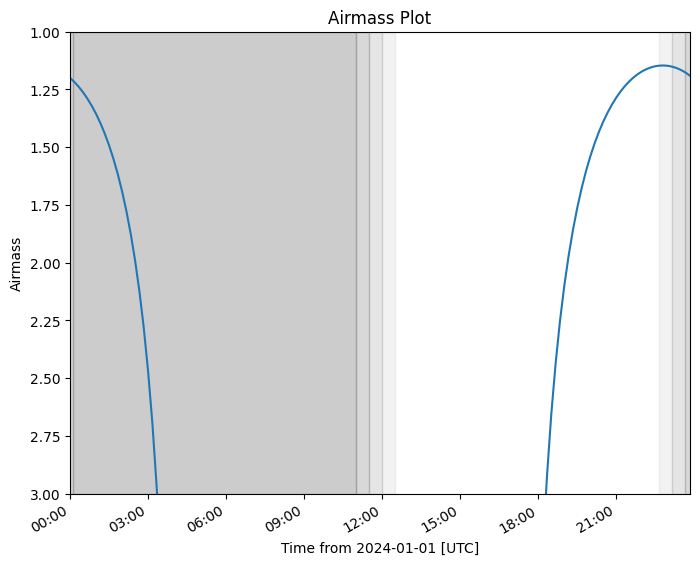

Created Target: <FixedTarget "fghhfg" at SkyCoord (ICRS): (ra, dec) in deg (0., 0.)>
FOV Radius: 0.0 arcmin


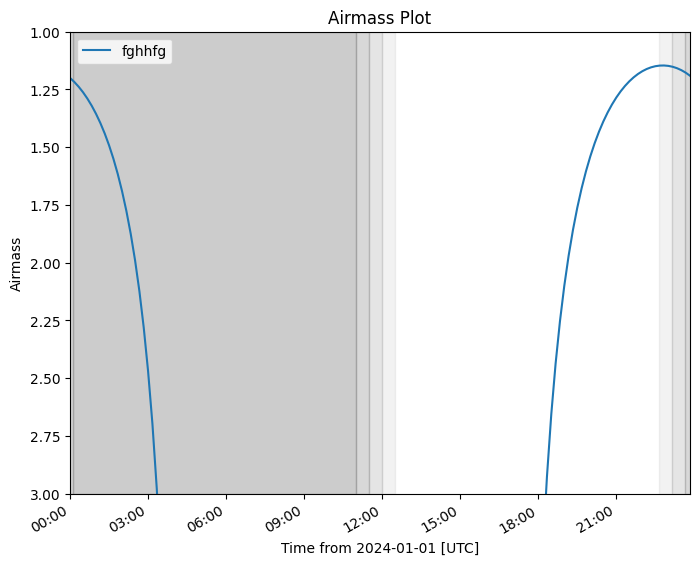

In [21]:
import astropy
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time, TimeDelta
from datetime import datetime
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import Layout, Button, Box, VBox, HBox
from IPython.display import display, clear_output
from astroplan import FixedTarget, Observer
from astroplan.plots import plot_airmass, plot_finder_image, plot_sky
import astropy.coordinates as coordinates
import warnings
warnings.filterwarnings("ignore", message="Numerical value without unit or explicit format passed to TimeDelta, assuming days")

# Define observer (RHO)
RHO = Observer(
    location=coordinates.EarthLocation(lat=29.4001, lon=-82.5862*u.deg, height=23*u.m),
    timezone='US/Eastern',
    name='Rosemary Hill Observatory'
)

# Initialize global variables
object_target = desired_date = fov_radius = None
style = {'description_width': 'initial'}


# Define widgets for RA/Dec input
ra_descs = ["RA Hours:", "RA Minutes:", "RA Seconds:"]
ra_auto = [widgets.FloatText(description=ra_descs[i], layout=Layout(flex='3 1 auto')) for i in range(len(ra_descs))]

dec_descs = ["Dec Degrees:", "Dec Minutes:", "Dec Seconds:"]
dec_auto = [widgets.FloatText(description=dec_descs[i], layout=Layout(flex='3 1 auto')) for i in range(len(dec_descs))]

name_widget = widgets.Text(description="Object Name:")

display(HBox(ra_auto), HBox(dec_auto), (name_widget))


# Function to convert RA/Dec widget values to degrees and create FixedTarget
def handle_submit_ra_dec(sender):
    ra_h, ra_m, ra_s = [ra_auto[i].value for i in range(len(ra_auto))]
    dec_d, dec_m, dec_s = [dec_auto[i].value for i in range(len(dec_auto))]
    ra_deg = (ra_h + ra_m / 60.0 + ra_s / 3600.0) * 15.0  # RA in degrees
    dec_deg = dec_d + dec_m / 60.0 + dec_s / 3600.0       # Dec in degrees
    if dec_d < 0:
            dec_deg = -dec_deg
    
    coords = [ra_m, ra_s, dec_m, dec_s]
    check = check_valid(ra_h, dec_d, ra_deg, dec_deg, coords)       # Including all of these vars might be unnecessary, I just don't want to think abt coords more than I have to - Pae

    if check:
        try:
            global object_target
            target_name = name_widget.value.strip()
            object_coord = SkyCoord(ra=ra_deg * u.deg, dec=dec_deg * u.deg, frame='icrs')
            object_target = FixedTarget(coord=object_coord, name=target_name)

            print(f"Created Target: {object_target}")
        except:
            print("Target creation failed - please check input coordinates.")       # Just to double make sure things don't break lol - Pae
    else:
        print("Target creation failed - please check input coordinates.")

submit_ra_dec_button = widgets.Button(description="Submit RA/Dec")
submit_ra_dec_button.on_click(handle_submit_ra_dec)
display(submit_ra_dec_button)

# Ensure input coords are valid
def check_valid(ra_h, dec_d, ra_deg, dec_deg, coords):
    if ra_h < 0 or ra_h > 24 or abs(ra_deg) > 360:        # Check RA
        return False
    if abs(dec_d) > 90 or abs(dec_deg) > 90:              # Check Dec
        return False
    if any(val > 60 for val in coords):     # Check arcmins and arcsecs to be smaller than 60
        return False
    else:
        return True


# Define widgets for Date input
time_descs = ["Year:", "Month:", "Day:"]
time_auto = [widgets.IntText(description=time_descs[i]) for i in range(len(time_descs))]
display(HBox(time_auto))

# Function to handle Date submission
def handle_submit_date(sender):
    year, month, day = [time_auto[i].value for i in range(len(time_auto))]
    try:
        global desired_date 
        desired_date = Time(datetime(year, month, day), format='datetime', scale='utc')
        print(f"Desired Date: {desired_date}")
    except:
        print("Error. Please check input values and try again.")

submit_date_button = widgets.Button(description="Submit Date")
submit_date_button.on_click(handle_submit_date)
display(submit_date_button)


# Define widgets for FOV input
fov_radius_widget = widgets.IntText(description="FOV in arcminutes:", style=style)
display(fov_radius_widget)

# Function to handle FOV submission (for Finder Image)
def handle_submit_fov(sender):
    global fov_radius
    fov_radius = fov_radius_widget.value * u.arcmin
    print(f"FOV Radius: {fov_radius}")

submit_fov_button = widgets.Button(description="Submit FOV")
submit_fov_button.on_click(handle_submit_fov)
display(submit_fov_button)


# Function to handle Airmass plotting
def handle_plot_airmass(sender):
    global object_target, desired_date
    if object_target is not None and desired_date is not None:
        try:
            time_range = desired_date + TimeDelta(range(0, 24*60, 10)*u.minute)
            fig, ax = plt.subplots(figsize=(8, 6))
            plot_airmass(object_target, observer=RHO, time=time_range, brightness_shading=True, ax=ax)
            ax.set_title("Airmass Plot")
            if object_target.name != "":
                plt.legend(loc='best')
        except:
            print("Error. Please check input values and try again.")
    else:
        print("Please enter RA/Dec and Date first.")

plot_airmass_button = widgets.Button(description="Plot Airmass")
plot_airmass_button.on_click(handle_plot_airmass)
display(plot_airmass_button)


# Function to handle Finder Image plotting
def handle_plot_finder_image(sender):
    global object_target, fov_radius
    if object_target is not None and fov_radius is not None:
        try:
            fig, ax = plt.subplots(figsize=(8, 6))
            ax, hdu = plot_finder_image(object_target, survey='DSS', fov_radius=fov_radius, ax=ax)
            ax.set_title('Finder Image')
        except:
            print("Error. Please check input values and try again.")
    else:
        print("Please enter RA/Dec and FOV first.")

plot_finder_button = widgets.Button(description="Plot Finder Image")
plot_finder_button.on_click(handle_plot_finder_image)
display(plot_finder_button)


# Function to calculate and plot sky positions at sunset and subsequent times
def handle_plot_sky_positions(sender):
    global object_target, desired_date
    if object_target is not None and desired_date is not None:
        try:
            sunset_times = [RHO.sun_set_time(desired_date), RHO.sun_set_time(desired_date) + 1*u.hour, 
                            RHO.sun_set_time(desired_date) + 2*u.hr, RHO.sun_set_time(desired_date) + 3*u.hr]
            sunset_times_titles = ["Object Position at Sunset", "Object Position 1 Hour After Sunset", 
                                   "Object Position 2 Hours After Sunset", "Object Position 3 Hours After Sunset"]
            
            for i in range(len(sunset_times_titles)):
                style_label = {"label" : sunset_times_titles[i]}
                plot_sky(target=object_target, observer=RHO, time=sunset_times[i], style_kwargs=style_label)
            plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5))
        except:
            print("Error. Please check input values and try again.")
    else:
        print("Please enter RA/Dec and Date first.")

plot_sky_positions_button = widgets.Button(description="Plot Sky Positions")
plot_sky_positions_button.on_click(handle_plot_sky_positions)
display(plot_sky_positions_button)